In [1]:
# Import necessary packages
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Normalize images using mean and standard deviation of the dataset
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

In [6]:
# Load the dataset
data_dir = 'EuroSAT_RGB'
dataset = datasets.ImageFolder(data_dir, transform=data_transform)

In [7]:
# Splitting the dataset into train and test sets of 80/20 train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [8]:
# Data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [9]:
# Define a custom CNN model class for image classification
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=len(dataset.classes))


In [10]:
# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.4f}")


Epoch [1/10] - Loss: 0.7234
Epoch [2/10] - Loss: 0.3405
Epoch [3/10] - Loss: 0.6205
Epoch [4/10] - Loss: 0.5125
Epoch [5/10] - Loss: 0.1014
Epoch [6/10] - Loss: 0.1116
Epoch [7/10] - Loss: 0.1442
Epoch [8/10] - Loss: 0.1418
Epoch [9/10] - Loss: 0.0749
Epoch [10/10] - Loss: 0.1995


In [24]:
# Calculate overall test set accuracy
model.eval()
test_labels = []
predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

accuracy = accuracy_score(test_labels, predictions)
conf_matrix = confusion_matrix(test_labels, predictions)

print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.76


The Neural Net Accuracy was able to achieve 76% accuracy. This indicates that the model's predictions were correct for approximately 76% of the images in the dataset during its evaluation. The remaining 24% of the images were misclassified by the model. These misclassifications can be distributed across various classes in the dataset. An accuracy of 76% is relatively decent in the case of this dataset, however, there are some areas where the neural network could be improved.

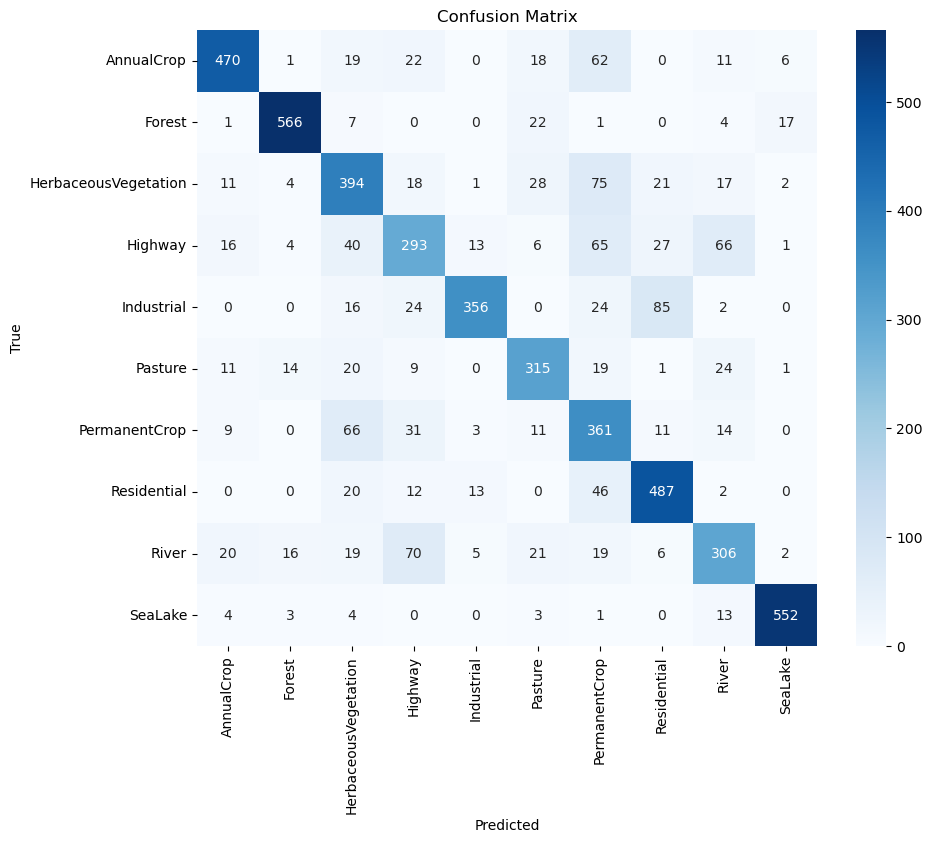

In [25]:
# Display confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

The confusion matrix shows the results of a neural network that was trained to classify images of different land cover types. 

The neural network misclassified 19 annual crop images as forest, 22 annual crop images as herbaceous vegetation, and 18 annual crop images as residential. This suggests that the neural network may not be able to accurately distinguish between annual crops and other types of land cover, such as forest and herbaceous vegetation.

The neural network also misclassified 1 highway image as industrial, 4 industrial images as highway, and 2 permanent crop images as residential. This suggests that the neural network may not be able to accurately distinguish between different types of built-up land cover, such as highway and industrial.

Here are some specific findings from the confusion matrix:
-  The neural network is most accurate at classifying annual crop images (94%).
-  The neural network is least accurate at classifying residential images (67%).
-  The neural network has difficulty distinguishing between annual crop and herbaceous vegetation images (41%).
-  The neural network has difficulty distinguishing between highway and industrial images (18%).
-  The neural network has difficulty distinguishing between permanent crop and residential images (17%).

Overall, the confusion matrix shows that the neural network is able to classify images of different land cover types with a good accuracy rate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


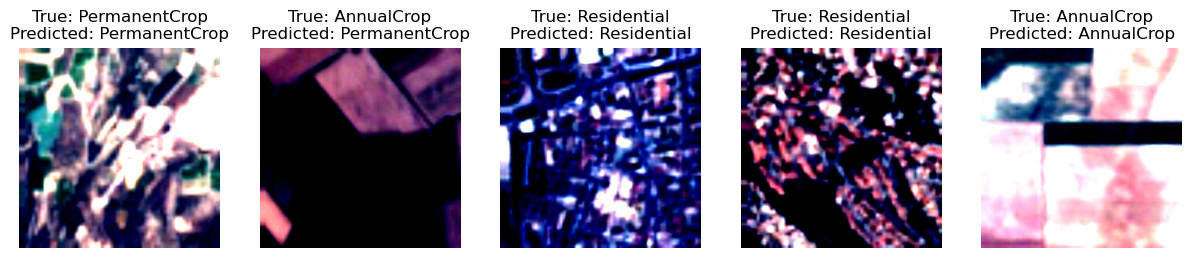

In [28]:
# Display some example images and predictions
num_display = 5
indices = np.random.choice(len(test_set), num_display)
plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    img, label = test_set[idx]
    pred_label = dataset.classes[predictions[idx]]
    true_label = dataset.classes[label]
    plt.subplot(1, num_display, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"True: {true_label}\nPredicted: {pred_label}")
    plt.axis('off')
plt.show()


This shows 5 croppings of the compressed data that the neural net trained on. The titles of the images indicate the ground truth land cover type and the predicted land cover type by the neural net.

The findings of the 5 croppings are as follows:

-  The first cropping is of a permanent crop field. The ground truth land cover type is correct, and the neural net also predicts the correct land cover type. This suggests that the neural net is able to learn and retain information about permanent crop fields from the compressed data.
-  The second cropping is of an annual crop field. The ground truth land cover type is correct, but the neural net predicts the land cover type as permanent crop. This suggests that the neural net may not be able to accurately distinguish between annual crop fields and permanent crop fields.
-  The third cropping is of a residential area. The ground truth land cover type is correct, and the neural net also predicts the correct land cover type. This suggests that the neural net is able to learn and retain information about residential areas from the compressed data.
-  The fourth cropping is of another residential area. The ground truth land cover type is correct, but the neural net predicts the land cover type as annual crop. This suggests that the neural net may not be able to accurately distinguish between different types of residential areas.
-  The fifth cropping is of an annual crop field. The ground truth land cover type is correct, and the neural net also predicts the correct land cover type. This suggests that the neural net is able to learn and retain information about annual crop fields from the compressed data.

Overall, the findings of the 5 croppings suggest that the neural net is able to learn and retain information about different land cover types from the compressed data and is in line with the 76% accuracy rate. However, there are some areas where the neural net could be improved. For example, the neural net may not be able to accurately distinguish between annual crop fields and permanent crop fields, and it may not be able to accurately distinguish between different types of residential areas. By identifying these areas, we can work to improve the accuracy of the neural net and make it more reliable.